In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/train.csv')

df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [15]:
len(df)

188533

In [16]:
df.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [17]:
df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [18]:
categorical_columns = ['brand', 'model', 'model_year', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
continuous_columns = ['milage']
target = ['price']

In [19]:
for c in categorical_columns:
    print(c)
    num_unique = df[c].nunique()
    print("Number of unique values:", num_unique)
    if num_unique <= 10:
        print("Unique values:", df[c].unique())
        
    print("-------")

brand
Number of unique values: 57
-------
model
Number of unique values: 1897
-------
model_year
Number of unique values: 34
-------
fuel_type
Number of unique values: 7
Unique values: ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
-------
engine
Number of unique values: 1117
-------
transmission
Number of unique values: 52
-------
ext_col
Number of unique values: 319
-------
int_col
Number of unique values: 156
-------
accident
Number of unique values: 2
Unique values: ['None reported' 'At least 1 accident or damage reported' nan]
-------
clean_title
Number of unique values: 1
Unique values: ['Yes' nan]
-------


- For `clean_title` we can impute nan with No. Looks like that makes sense.
- For nans in `accident` and `fuel_type`, we will start with dropping off all the nans and then see.

In [23]:
# Impute 'clean_title' NaN values with 'No'
df_clean_title = df.copy()
df_clean_title['clean_title'] = df_clean_title['clean_title'].fillna('No')

# Drop rows with NaN values in 'accident' and 'fuel_type'
df_no_nan = df_clean_title.dropna(subset=['accident', 'fuel_type'])

print(f"Number of rows after handling NaN values: {len(df_no_nan)}")
print(f"Number of rows before handling NaN values: {len(df)}")
print(f"Number of rows with NaN values in 'accident' or 'fuel_type': {len(df) - len(df_no_nan)}")


Number of rows after handling NaN values: 181067
Number of rows before handling NaN values: 188533
Number of rows with NaN values in 'accident' or 'fuel_type': 7466


count    181067.000000
mean      66894.919996
std       49905.983232
min         100.000000
25%       25000.000000
50%       59400.000000
75%       96476.000000
max      405000.000000
Name: milage, dtype: float64


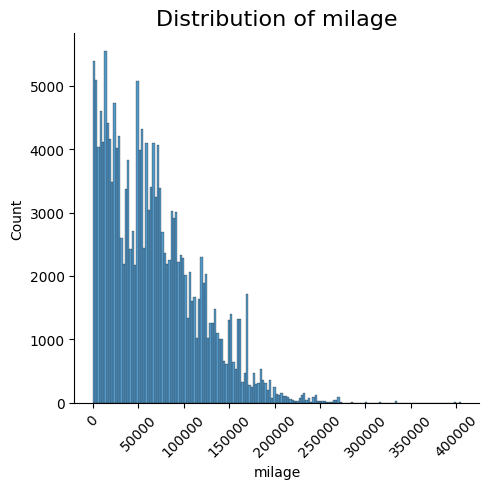

In [28]:
# Convert 'milage' to numeric, replacing non-numeric values with NaN
# errors='coerce' is used to handle any non-numeric values in the 'milage' column
# This is necessary because some entries might contain non-numeric characters or be in an incorrect format
# By using 'coerce', we ensure that these problematic values are converted to NaN rather than raising an error
df_no_nan.loc[:, 'milage'] = pd.to_numeric(df_no_nan['milage'], errors='coerce')

print(df_no_nan['milage'].describe())

fig = sns.displot(data=df_no_nan, x='milage')
plt.title('Distribution of milage', fontsize=16)
plt.xticks(rotation=45)  # doing this for readability
plt.tight_layout()  # Adjust the layout to prevent label cutoff
plt.show()


count    1.810670e+05
mean     4.326172e+04
std      7.869092e+04
min      2.000000e+03
25%      1.675000e+04
50%      3.000000e+04
75%      4.860000e+04
max      2.954083e+06
Name: price, dtype: float64


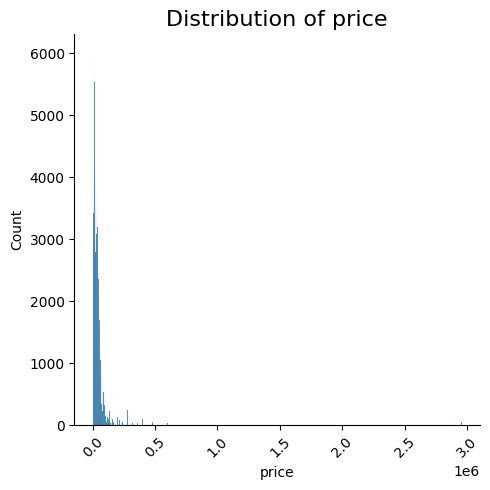

In [29]:
# Convert 'price' to numeric, replacing non-numeric values with NaN
df_no_nan.loc[:, 'price'] = pd.to_numeric(df_no_nan['price'], errors='coerce')

print(df_no_nan['price'].describe())

fig = sns.displot(data=df_no_nan, x='price')
plt.title('Distribution of price', fontsize=16)
plt.xticks(rotation=45)  # doing this for readability
plt.tight_layout()  # Adjust the layout to prevent label cutoff
plt.show()


# Data cleaning and transformation
- Transform the price and milage to log scale, because the distribution is skewed and that will cause the LinearRegression model to fit to the data well, by making it more normal.
- All the categorical columns are one hot encoded, and we will drop the first column to avoid multicollinearity.

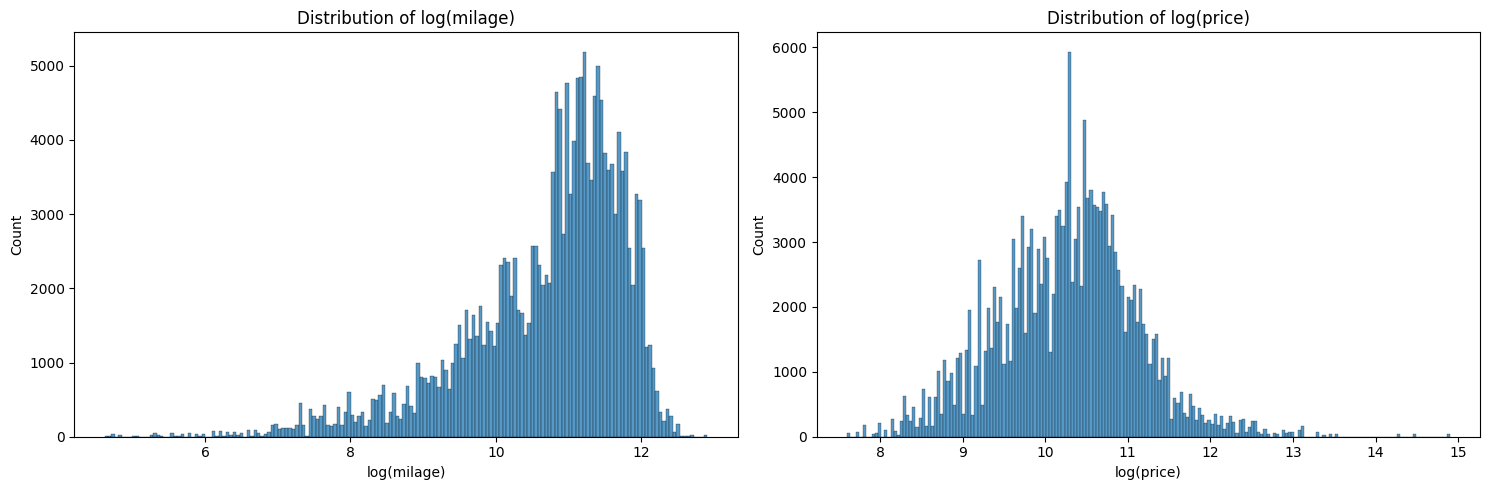

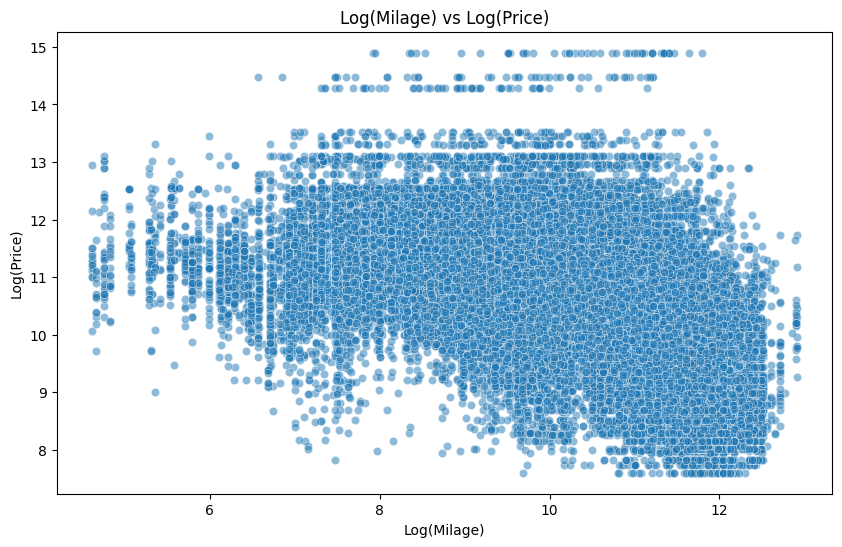

In [31]:
# Log transform mileage and price
df_transformed = df_no_nan.copy()  # Create a copy to avoid SettingWithCopyWarning
df_transformed.loc[:, 'log_milage'] = np.log1p(df_transformed['milage'])
df_transformed.loc[:, 'log_price'] = np.log1p(df_transformed['price'])

# Plot log-transformed distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_transformed, x='log_milage', ax=ax1)
ax1.set_title('Distribution of log(milage)')
ax1.set_xlabel('log(milage)')

sns.histplot(data=df_transformed, x='log_price', ax=ax2)
ax2.set_title('Distribution of log(price)')
ax2.set_xlabel('log(price)')

plt.tight_layout()
plt.show()

# Scatter plot of log(milage) vs log(price)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_transformed, x='log_milage', y='log_price', alpha=0.5)
plt.title('Log(Milage) vs Log(Price)')
plt.xlabel('Log(Milage)')
plt.ylabel('Log(Price)')
plt.show()

In [34]:
# Create a new dataframe with log-transformed mileage and price, and original price
df_encoded = df_transformed[['log_milage', 'log_price', 'price']].copy()

# List of categorical columns to encode, including 'model_year'
cat_columns = ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

# Perform one-hot encoding for each categorical column
for col in cat_columns:
    # Get dummies and drop the first column to avoid multicollinearity
    dummies = pd.get_dummies(df_no_nan[col], prefix=col, drop_first=True, dtype=int)
    
    # Join the encoded columns to the new dataframe
    df_encoded = pd.concat([df_encoded, dummies], axis=1)

df_encoded.head()


,log_milage,log_price,price,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,...,int_col_Very Light Cashmere,int_col_WHITE,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,accident_None reported,clean_title_Yes
0,12.269052,8.343078,4200,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,11.872354,8.517193,4999,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,11.825778,9.539716,13900,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,9.878221,10.714440,45000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,8.907748,11.487618,97500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


# Train a LinearRegression model

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

np.random.seed(42)

X = df_encoded.drop(['log_price', 'price'], axis=1)
y = df_encoded['log_price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 8215390514520888.0000


The above MSE value is 8215390514520888.0000, WTF! That is a very high value. How did we even get to this? It is time for some model debugging.

Model Coefficients:
[-0.18189305 -0.18733625  0.19896287 ...  0.10945913  0.08541885
 -0.00454768]

Model Intercept:
-163237745.33149412


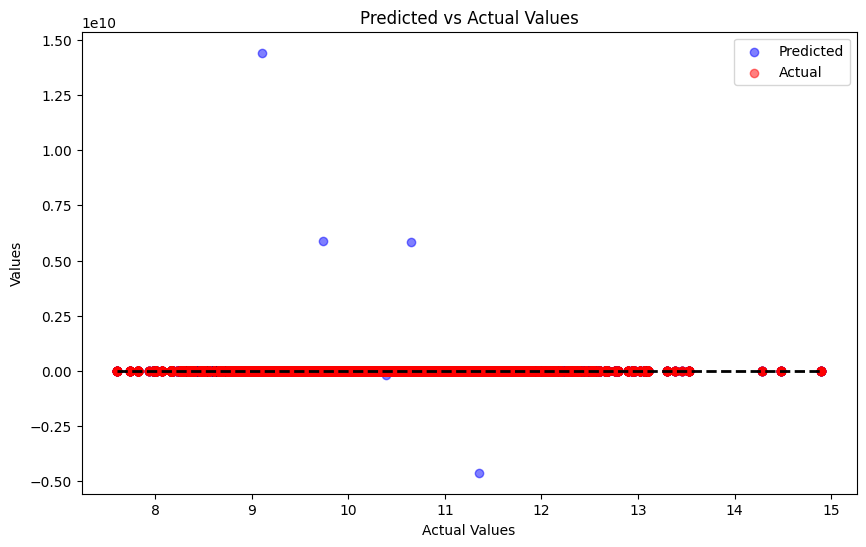

In [38]:
print("Model Coefficients:")
print(model.coef_)
print("\nModel Intercept:")
print(model.intercept_)

# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5, color='blue', label='Predicted')
plt.scatter(y_valid, y_valid, alpha=0.5, color='red', label='Actual')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Values')
plt.legend()
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)  # Add diagonal line

looks like intercept is way off. Let's retrain the model without the intercept.

In [39]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1187091023548910.2500


OLD MSE: 8215390514520888.0000

New MSE: 1187091023548910.2500

Still absolute garbage!

Text(0, 0.5, 'Values')

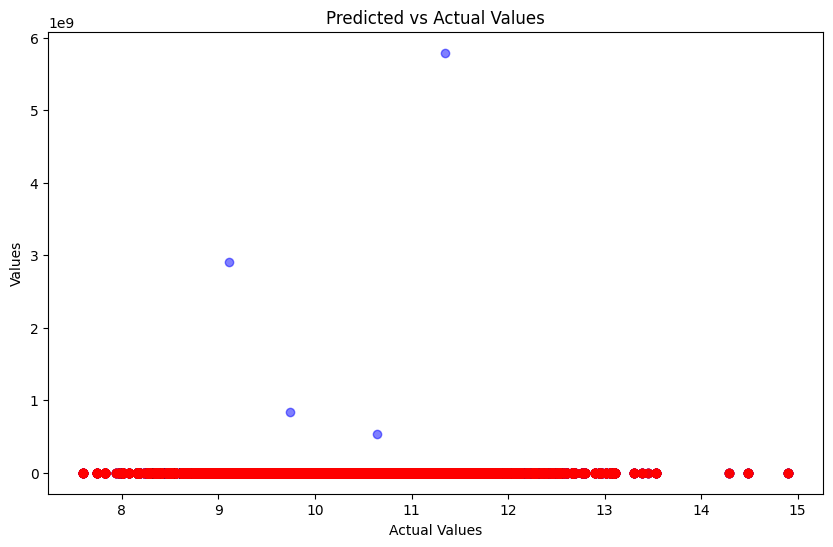

In [40]:
# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5, color='blue', label='Predicted')
plt.scatter(y_valid, y_valid, alpha=0.5, color='red', label='Actual')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Values')

Why the fuck is the model predicting values in the range of 10^9, when the actual values are close to 0??!!!

In [41]:
from sklearn.preprocessing import MinMaxScaler

df_scaled = df_encoded.copy()

scaler = MinMaxScaler()

df_scaled[['scaled_log_price', 'scaled_log_milage']] = scaler.fit_transform(df_scaled[['log_price', 'log_milage']])

df_scaled = df_scaled.drop(['log_price', 'log_milage'], axis=1)

df_scaled.head()

,price,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,...,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,accident_None reported,clean_title_Yes,scaled_log_price,scaled_log_milage
0,4200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.101637,0.922547
1,4999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.125497,0.874732
2,13900,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0.265621,0.869118
3,45000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.426601,0.634374
4,97500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.532556,0.517401


In [96]:
# Constants
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Prepare the data
X = df_scaled.drop(['price', 'scaled_log_price'], axis=1)
y = df_scaled['scaled_log_price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Initialize and train the model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")


Mean Squared Error: 312909413658973504.000


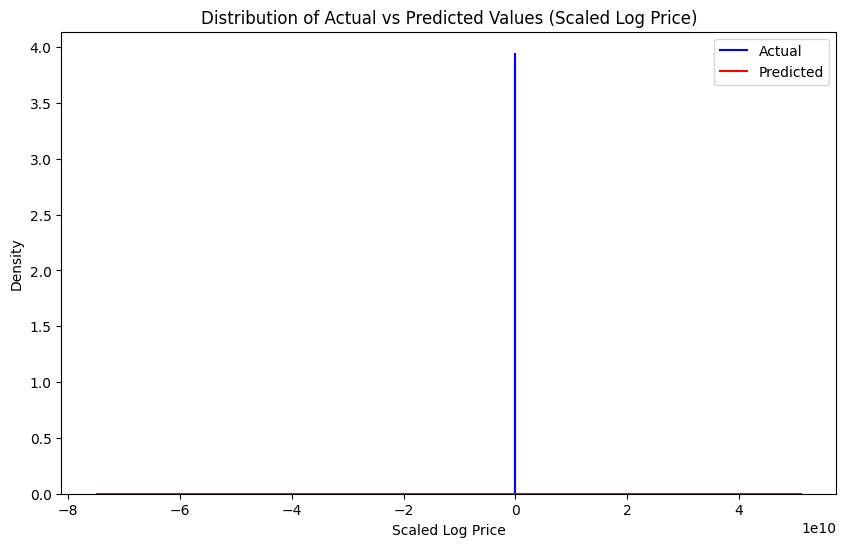

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.kdeplot(data=y_test, label='Actual', color='blue')
sns.kdeplot(data=y_pred, label='Predicted', color='red')

plt.title('Distribution of Actual vs Predicted Values (Scaled Log Price)')
plt.xlabel('Scaled Log Price')
plt.ylabel('Density')
plt.legend()
plt.show()


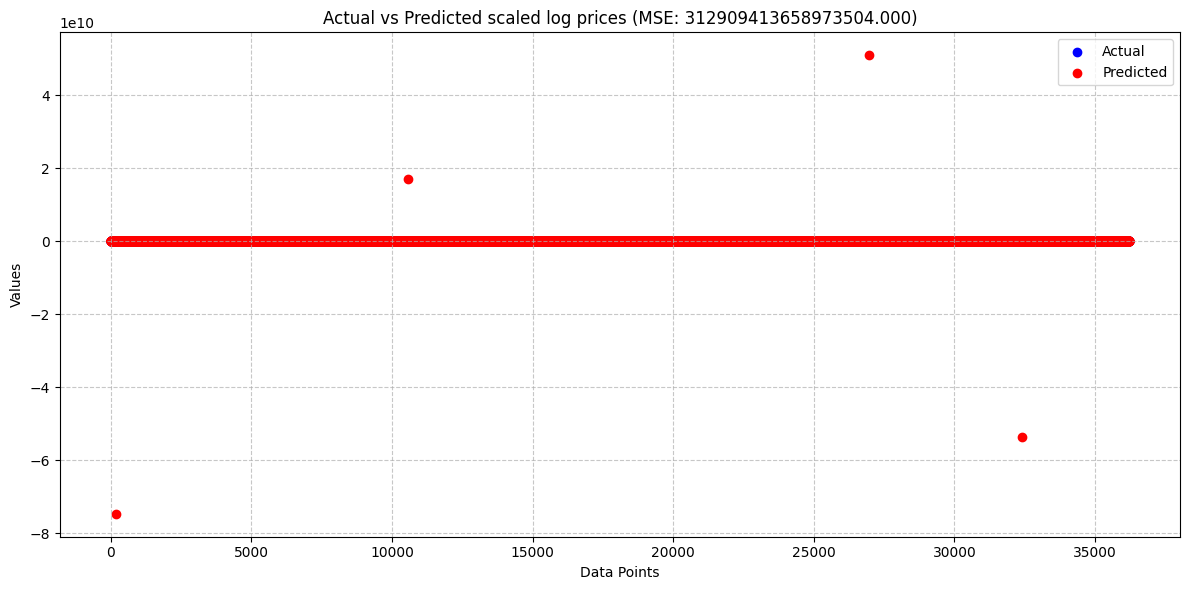

In [98]:
actual_prices = y_test
predicted_prices = y_pred
squared_errors = [mean_squared_error([actual], [pred]) for actual, pred in zip(actual_prices, predicted_prices)]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(actual_prices)), actual_prices, color='blue', label='Actual')
plt.scatter(range(len(predicted_prices)), predicted_prices, color='red', label='Predicted')
plt.title(f'Actual vs Predicted scaled log prices (MSE: {mse:.3f})')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


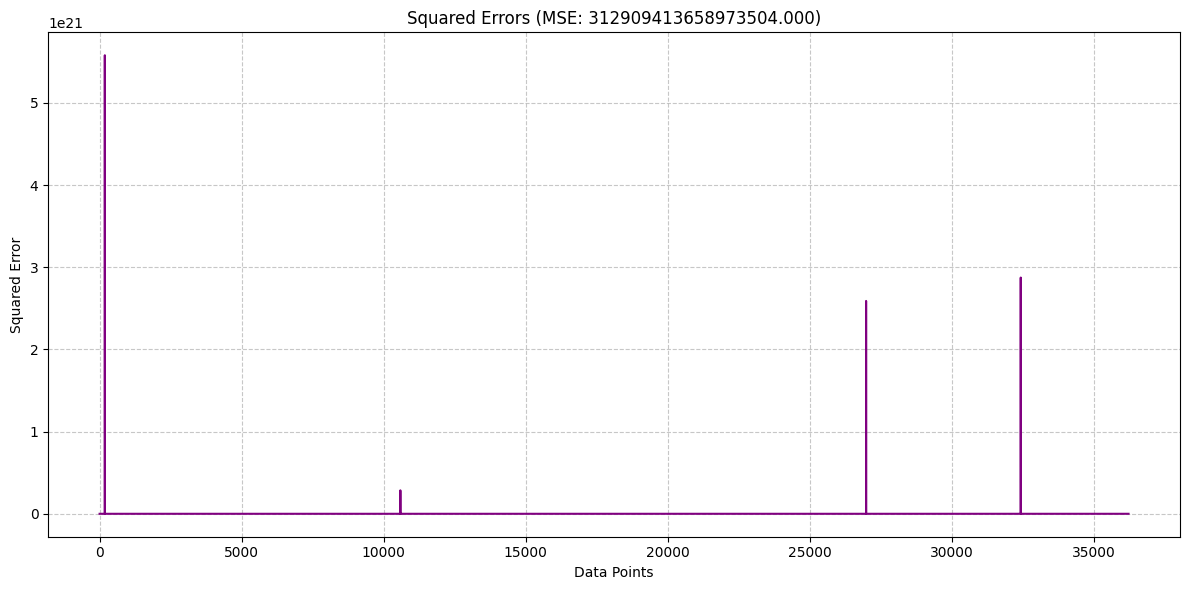

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(squared_errors)), squared_errors, color='purple')
plt.title(f'Squared Errors (MSE: {mse:.3f})')
plt.xlabel('Data Points')
plt.ylabel('Squared Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [100]:
HIGH_ERROR_THRESHOLD = 10
N_TOP_CONTRIBUTORS = 5


high_squared_errors = [(i, error) for i, error in enumerate(squared_errors) if error > HIGH_ERROR_THRESHOLD]

high_error_df = pd.DataFrame([
    {
        'Data Point': i,
        'Actual Scaled Log Price': y_test.values[i],
        'Predicted Scaled Log Price': y_pred[i],
        'Squared Error': error
    }
    for i, error in high_squared_errors
])

# Calculate contributions for each feature
contributions = X_test.iloc[high_error_df['Data Point']] * model.coef_

# Get top 10 contributors by magnitude
top_contributors = contributions.abs().mean().nlargest(N_TOP_CONTRIBUTORS)
for feature in top_contributors.index:
    high_error_df[f'Contribution_{feature}'] = contributions[feature].values
    high_error_df[f'Weight_{feature}'] = model.coef_[X_test.columns.get_loc(feature)]
    high_error_df[f'Input_{feature}'] = X_test.iloc[high_error_df['Data Point']][feature].values

# Sort the dataframe
high_error_df = high_error_df.sort_values('Squared Error', ascending=False)
high_error_df.head()

,Data Point,Actual Scaled Log Price,Predicted Scaled Log Price,Squared Error,Contribution_model_Air Pure,Weight_model_Air Pure,Input_model_Air Pure,Contribution_model_Leaf SV PLUS,Weight_model_Leaf SV PLUS,Input_model_Leaf SV PLUS,Contribution_model_Model S Plaid,Weight_model_Model S Plaid,Input_model_Model S Plaid,Contribution_brand_smart,Weight_brand_smart,Input_brand_smart,Contribution_scaled_log_milage,Weight_scaled_log_milage,Input_scaled_log_milage
0,184,0.417131,-7.470458e+10,5.580774e+21,-7.470458e+10,-7.470458e+10,1,-0.000000e+00,-5.361924e+10,0,0.000000e+00,5.089681e+10,0,0.000000e+00,1.689435e+10,0,-0.174419,-0.206806,0.843390
3,32419,0.293208,-5.361924e+10,2.875023e+21,-0.000000e+00,-7.470458e+10,0,-5.361924e+10,-5.361924e+10,1,0.000000e+00,5.089681e+10,0,0.000000e+00,1.689435e+10,0,-0.170662,-0.206806,0.825228
2,26976,0.206061,5.089681e+10,2.590486e+21,-0.000000e+00,-7.470458e+10,0,-0.000000e+00,-5.361924e+10,0,5.089681e+10,5.089681e+10,1,0.000000e+00,1.689435e+10,0,-0.178993,-0.206806,0.865511
1,10585,0.513749,1.689435e+10,2.854190e+20,-0.000000e+00,-7.470458e+10,0,-0.000000e+00,-5.361924e+10,0,0.000000e+00,5.089681e+10,0,1.689435e+10,1.689435e+10,1,-0.076414,-0.206806,0.369494


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

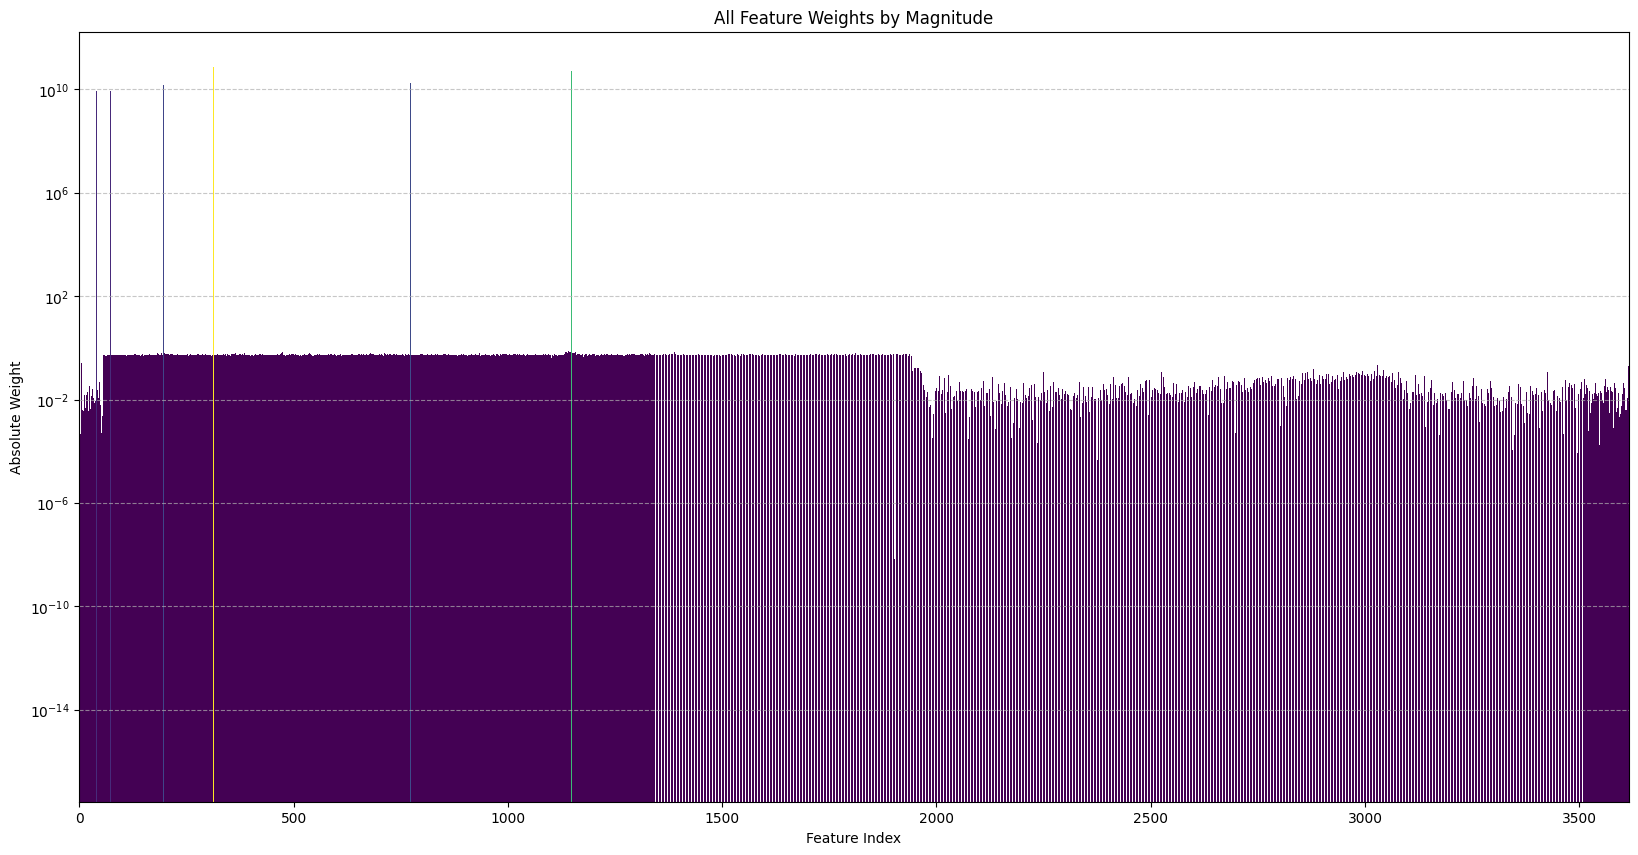

In [102]:
# Visualize all model weights' magnitudes
plt.figure(figsize=(20, 10))  # Increased figure size for better visibility
weights = np.abs(model.coef_)
feature_indices = np.arange(len(weights))

# Create a mappable object for the colorbar
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work correctly

plt.bar(feature_indices, weights, color=plt.cm.viridis(norm(weights)))
plt.title('All Feature Weights by Magnitude')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.yscale('log')  # Using log scale for y-axis to better visualize differences
plt.xlim(-1, len(weights))  # Set x-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a colorbar to represent magnitude
cbar = plt.colorbar(sm, label='Weight Magnitude')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of features: {len(weights)}")
print(f"Max weight: {np.max(weights):.4f}")
print(f"Min weight: {np.min(weights):.4f}")
print(f"Mean weight: {np.mean(weights):.4f}")
print(f"Median weight: {np.median(weights):.4f}")
